In [69]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = '../../results/shuffle_experiment/default'

sns.set_theme(style="white")

def draw_checkpoint_line(ax, df_model_results, palette, linestyles):
    for idx_exp, experiment in enumerate(df_model_results['Experiment'].unique()):
        df_experiment = df_model_results[df_model_results['Experiment'] == experiment]
        df_experiment = df_experiment.sort_values(by='Experiment')

        ax.axvline(x=df_experiment['Epoch'].iloc[0], color=palette[idx_exp], linestyle=linestyles[idx_exp], linewidth=1)


def plot_loss_curves(df_losses, palette=sns.color_palette("tab10")):
    models = df_losses['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(ncols=2,nrows=len(models), figsize=(12, 6*len(models)), sharex=True, sharey=True)

    for idx, m in enumerate(models):
        df_model = df_losses[df_losses['Model'] == m]
        df_model = df_model.sort_values(by='Experiment')

        sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
        sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
        ax[idx, 0].set(title=f'Train Loss - {m}', ylabel='BCE Loss')
        ax[idx,1].set(title=f'Validation Loss - {m}')
                
    plt.tight_layout()
    
    return fig

def plot_auroc_curves(df, df_results=None, palette=sns.color_palette("tab10"), linestyles = ['-.','--',':']):
    models = df['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True, ncols=len(models))

    for idx, m in enumerate(models):
        df_model = df[df['Model'] == m]
        sns.lineplot(data=df_model, x='Epoch', y='val_auroc', hue='Experiment', ax=ax[idx])
        ax[idx].set(title=f'Validation AUROC - {m}', ylabel='AUROC')

        if df_results is not None:
            df_model_results = df_results[df_results['Model'] == m]
            draw_checkpoint_line(ax[idx], df_model_results, palette, linestyles)

    plt.tight_layout()

    return fig

def plot_all_auroc_curves(df_losses):
    sns.set_palette("tab10")
    sns.set_style("dark")

    models = df_losses['Model'].unique()
    tasks = df_losses['Task'].unique()

    fig, ax = plt.subplots(figsize=(3*len(models)+3, 3*len(tasks)), sharex=True, sharey=True, ncols=len(models), nrows=len(tasks))

    for idx, t in enumerate(tasks):
        for jdx, m in enumerate(models):
            df_model = df_losses[(df_losses['Model'] == m) & (df_losses['Task'] == t)]
            sns.lineplot(data=df_model, x='Epoch', y='val_auroc', hue='Experiment', ax=ax[idx, jdx])
            ax[idx, jdx].set_ylabel('AUROC')

    for idx, a in enumerate(ax[0,:]):
        a.set_title(f'{models[idx]}')

    for idx, a in enumerate(ax[:,0]):
        ax_double = a.twinx()
        ax_double.yaxis.set_label_position("left")
        ax_double.spines['left'].set_position(('axes', -0.4))
        ax_double.spines['left'].set_visible(False)
        ax_double.set_ylabel(f'{tasks[idx]}', ha='right', va='center', rotation=0)
        ax_double.set_yticks([])

    plt.tight_layout()

def print_test_results(df):
    print(df[['Task', 'Experiment', 'Model','Epoch','test_loss','test_auroc_avg']].sort_values(by='test_auroc_avg', ascending=False).to_markdown(index=False, floatfmt=".3f"))


In [324]:
def read_results(experiment_path, model,df_filename):
    df = pd.read_csv(os.path.join(experiment_path, model, df_filename))
    splits = experiment.split('_')
    df['Task'] = splits[0] + ' ' + splits[1]
    df['Experiment'] = splits[-1] if len(splits) > 2 else 'default'
    df['Model'] = model
    return df

dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):
    if experiment.startswith('.'):
        continue

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment)
    for model in os.listdir(experiment_path):
        if model.startswith('.'):
            continue
        print(f'\t Processing {model}...')
        
        if 'losses.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_losses.append(read_results(experiment_path, model,'losses.csv'))

        if 'best_model_metrics.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_tests.append(read_results(experiment_path, model,'best_model_metrics.csv'))

df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)       

Processing histone_modification_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing histone_modification_default (1 worker)...
	 Processing hyenadna-tiny-1k...
Processing histone_modification...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...


In [325]:
df_losses_hyenadna = df_losses[df_losses['Model'] == 'hyenadna-tiny-1k']
df_tests_hyenadna = df_tests[df_tests['Model'] == 'hyenadna-tiny-1k']

In [326]:
df_losses = df_losses[~df_losses['Experiment'].str.contains('1 worker')]
df_losses

,Epoch,train_loss,val_loss,val_auroc,training_time,Task,Experiment,Model
0,1,0.267686,0.249859,0.765585,1347.698827,histone modification,shuffled,resnetlm
1,2,0.262581,0.247113,0.771852,1350.800478,histone modification,shuffled,resnetlm
2,3,0.260834,0.244994,0.777282,1369.690360,histone modification,shuffled,resnetlm
3,4,0.259744,0.245575,0.778447,1371.856758,histone modification,shuffled,resnetlm
4,5,0.258750,0.243285,0.780176,1428.414173,histone modification,shuffled,resnetlm
...,...,...,...,...,...,...,...,...
1013,41,0.216024,0.305641,0.883614,9489.972729,cpg methylation,default,dnabert2
1014,42,0.215104,0.312850,0.880016,9324.824975,cpg methylation,default,dnabert2
1015,43,0.215004,0.304948,0.884210,9374.384868,cpg methylation,default,dnabert2
1016,44,0.214592,0.304536,0.884516,9522.844662,cpg methylation,default,dnabert2


In [328]:
df_tests = df_tests[~df_tests['Experiment'].str.contains('1 worker')]
df_tests

,Epoch,train_loss,val_loss,val_auroc,training_time,test_loss,test_auroc_avg,test_auroc_0,test_auroc_1,test_auroc_2,...,test_auroc_11,test_auroc_12,test_auroc_13,test_auroc_14,test_auroc_15,test_auroc_16,test_auroc_17,Task,Experiment,Model
0,19.0,0.253326,0.240857,0.790121,1400.757037,0.254662,0.784729,0.714357,0.872675,0.847422,...,0.898029,0.857552,0.776571,0.768605,0.729740,0.729777,0.739301,histone modification,shuffled,resnetlm
1,94.0,0.257448,0.244612,0.778233,713.894150,0.256740,0.772113,0.692283,0.872751,0.805683,...,0.890352,0.849302,0.766969,0.764045,0.718760,0.725095,0.724017,histone modification,shuffled,hyenadna-tiny-1k
2,8.0,0.256876,0.244331,0.780911,1615.820260,0.256145,0.775889,0.708935,0.865047,0.838336,...,0.889799,0.850010,0.766145,0.759227,0.720978,0.724435,0.728069,histone modification,shuffled,dnabert2
4,45.0,0.252437,0.242488,0.783832,1510.105978,0.254732,0.780372,0.707149,0.869083,0.840124,...,0.893078,0.854970,0.773807,0.760691,0.727164,0.727157,0.726631,histone modification,default,resnetlm
5,100.0,0.259527,0.245137,0.771724,760.968752,0.257992,0.765966,0.689680,0.868135,0.803676,...,0.888780,0.846140,0.760173,0.758602,0.709229,0.712227,0.713872,histone modification,default,hyenadna-tiny-1k
6,8.0,0.259522,0.243813,0.776891,1593.374574,0.256802,0.772736,0.702117,0.861554,0.833431,...,0.893529,0.849470,0.763919,0.757385,0.715550,0.719315,0.720035,histone modification,default,dnabert2


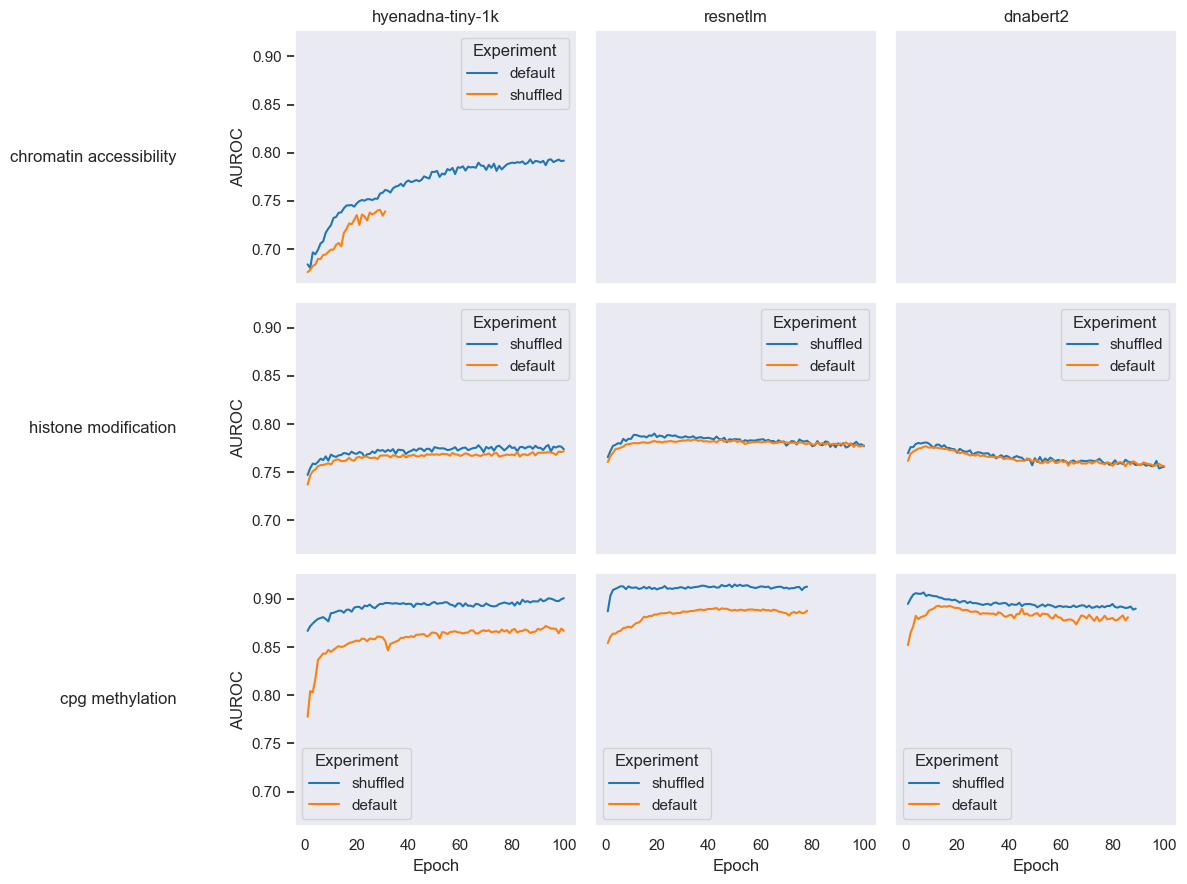

In [70]:
plot_all_auroc_curves(df_losses)

## CpG Methylation

In [329]:
df_cpg = df_losses[df_losses['Task'] == 'cpg methylation']
df_cpg

,Epoch,train_loss,val_loss,val_auroc,training_time,Task,Experiment,Model
300,1,0.273666,0.265990,0.887118,11185.061165,cpg methylation,shuffled,resnetlm
301,2,0.252986,0.254817,0.903391,11017.207081,cpg methylation,shuffled,resnetlm
302,3,0.240614,0.244107,0.909345,11003.908748,cpg methylation,shuffled,resnetlm
303,4,0.234398,0.243757,0.910577,11221.629020,cpg methylation,shuffled,resnetlm
304,5,0.230006,0.241715,0.911931,10937.400368,cpg methylation,shuffled,resnetlm
...,...,...,...,...,...,...,...,...
1013,41,0.216024,0.305641,0.883614,9489.972729,cpg methylation,default,dnabert2
1014,42,0.215104,0.312850,0.880016,9324.824975,cpg methylation,default,dnabert2
1015,43,0.215004,0.304948,0.884210,9374.384868,cpg methylation,default,dnabert2
1016,44,0.214592,0.304536,0.884516,9522.844662,cpg methylation,default,dnabert2


/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:30: UserWarning: The palette list has more values (10) than needed (2), which m

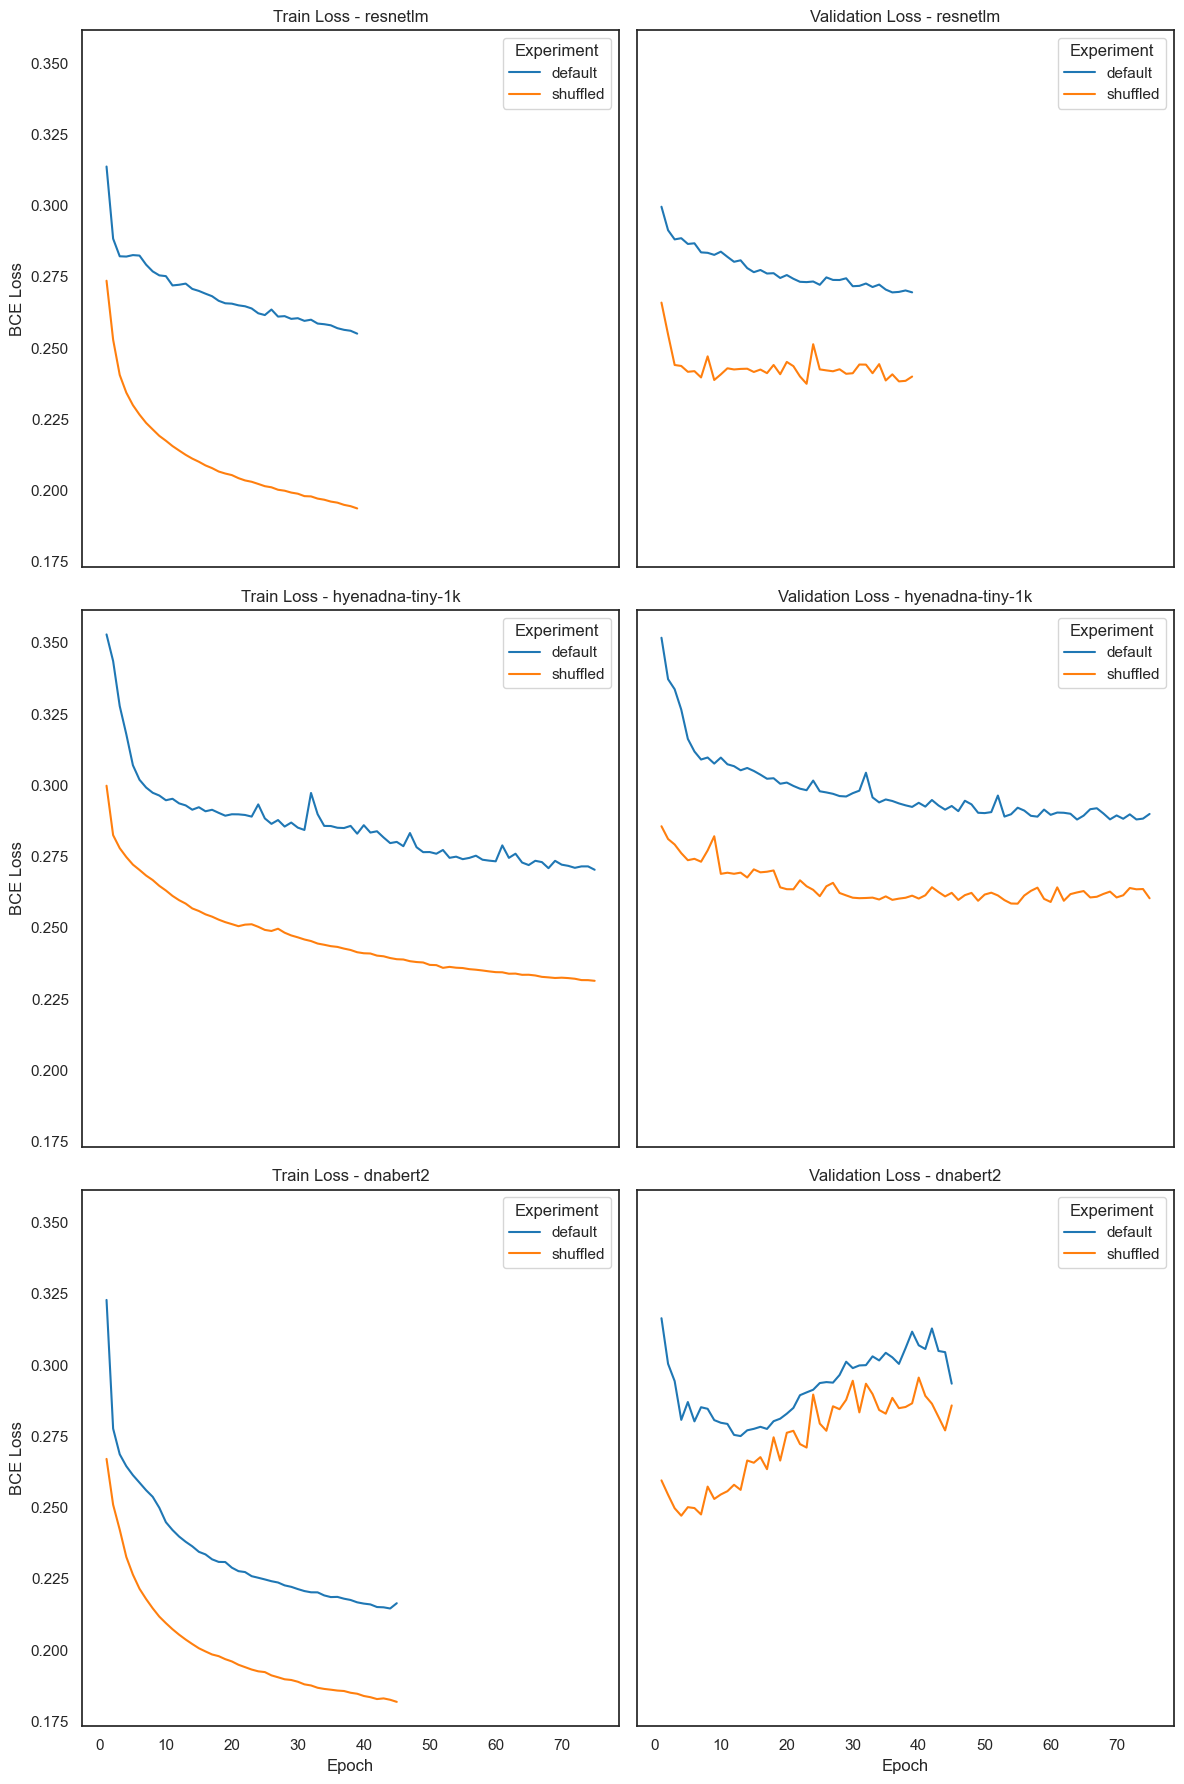

In [330]:
fig = plot_loss_curves(df_cpg)

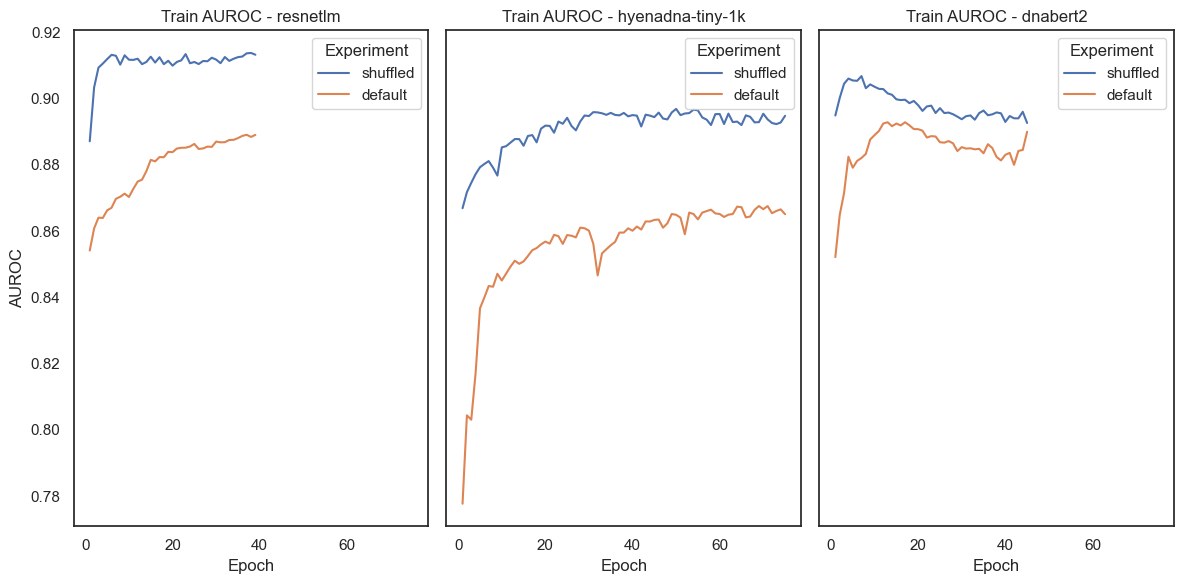

In [331]:
fig = plot_auroc_curves(df_cpg)

## Histone Modification

In [332]:
df_losses_histone = df_losses[df_losses['Task'] == 'histone modification']
df_tests_histone = df_tests[df_tests['Task'] == 'histone modification']

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/245032154.py:30: UserWarning: The palette list has more values (10) than needed (2), which m

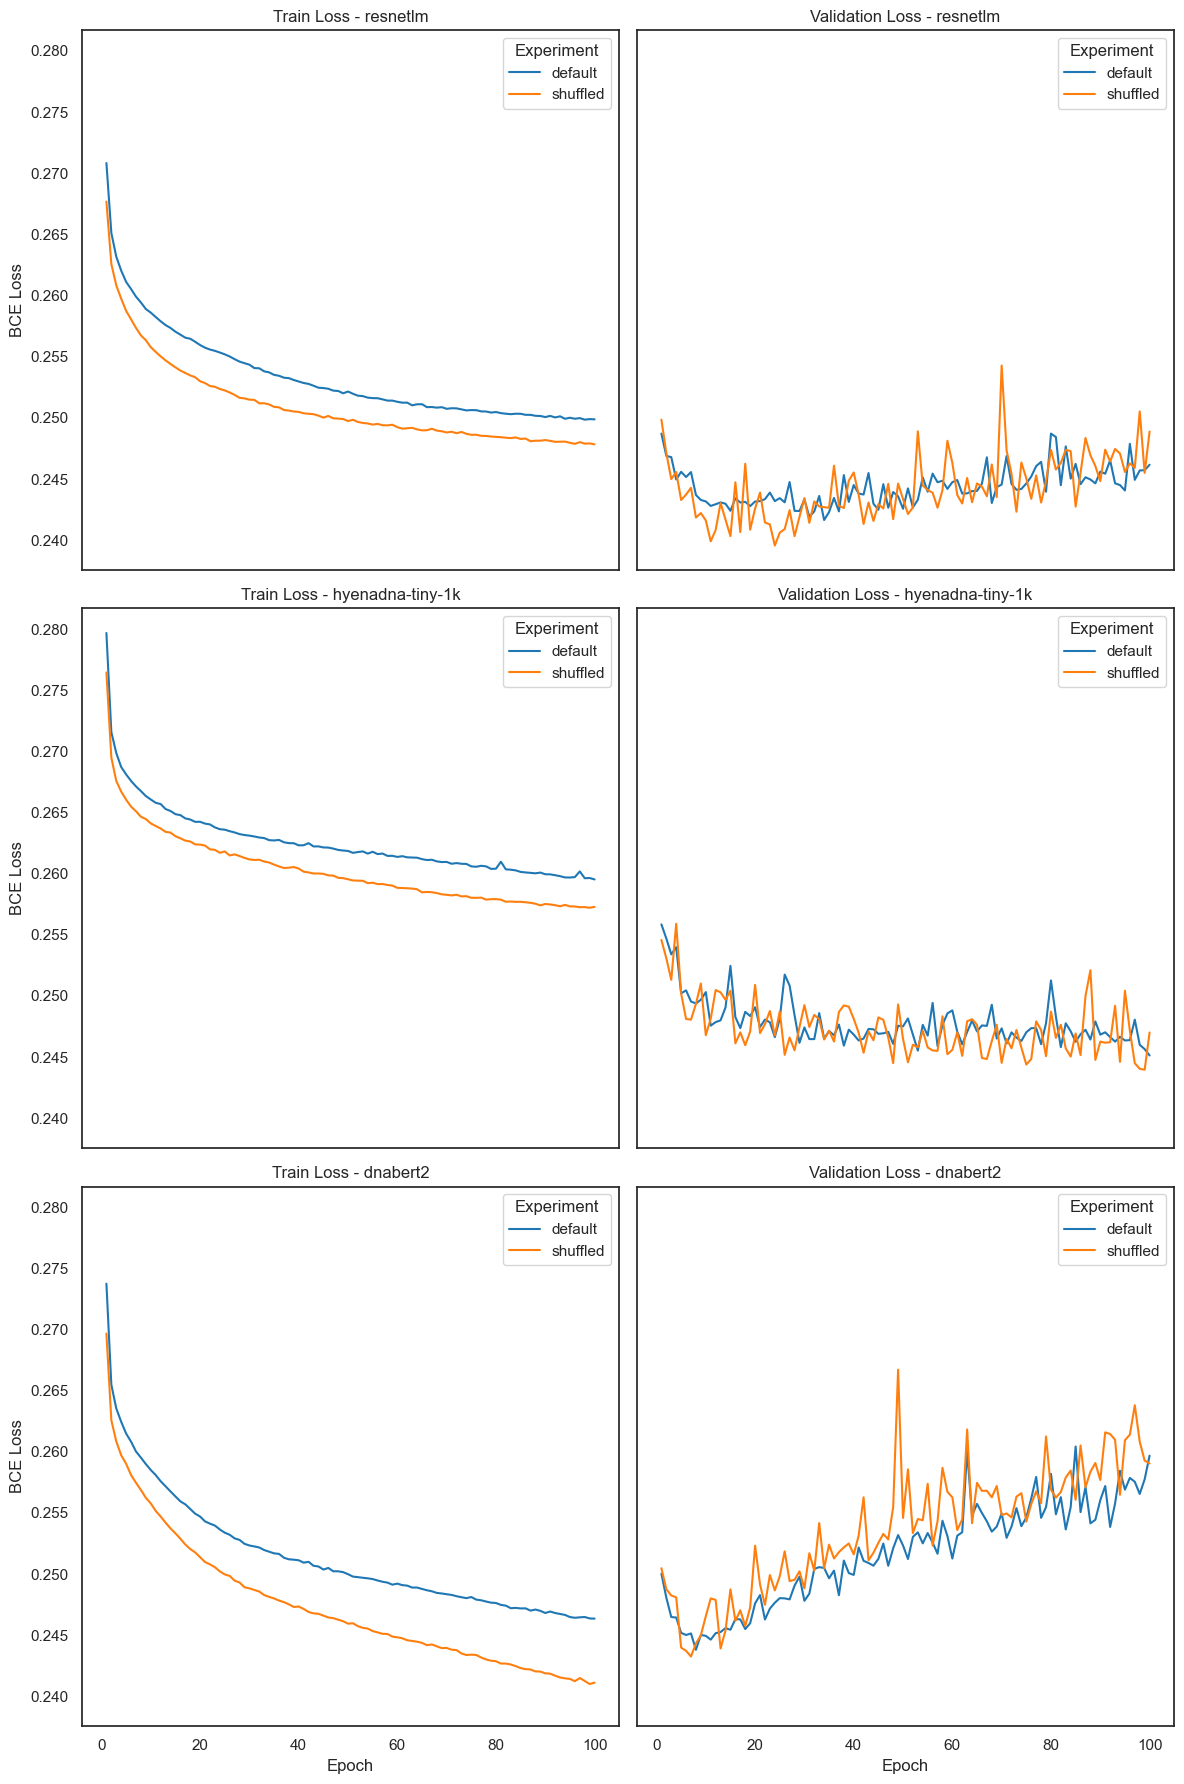

In [333]:
fig = plot_loss_curves(df_losses_histone)
# plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'losses_{MODEL}.png', dpi=300)

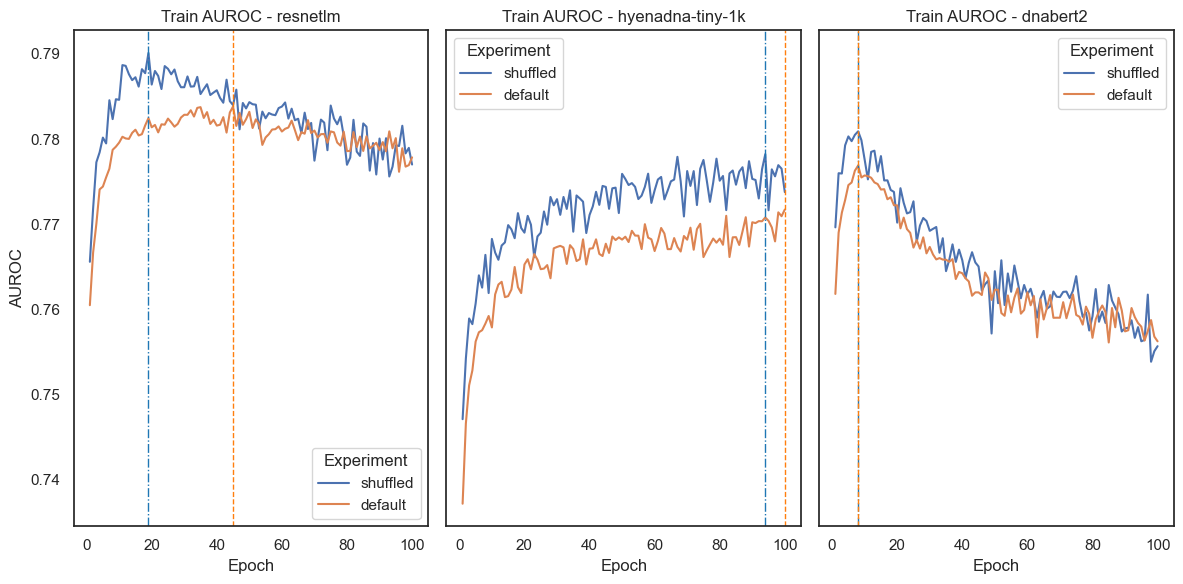

In [334]:
fig = plot_auroc_curves(df_losses_histone, df_tests_histone)
# plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'val_AUROC_{MODEL}.png', dpi=300)

In [335]:
print_test_results(df_tests_histone)

| Task                 | Experiment   | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:-------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled     | resnetlm         |  19.000 |       0.255 |            0.785 |
| histone modification | default      | resnetlm         |  45.000 |       0.255 |            0.780 |
| histone modification | shuffled     | dnabert2         |   8.000 |       0.256 |            0.776 |
| histone modification | default      | dnabert2         |   8.000 |       0.257 |            0.773 |
| histone modification | shuffled     | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default      | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |


## Training Times

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_8730/315094492.py:6: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(data=df_losses, x='Model', y='training_time_hours', hue='Group', palette=sns.color_palette('Paired'))


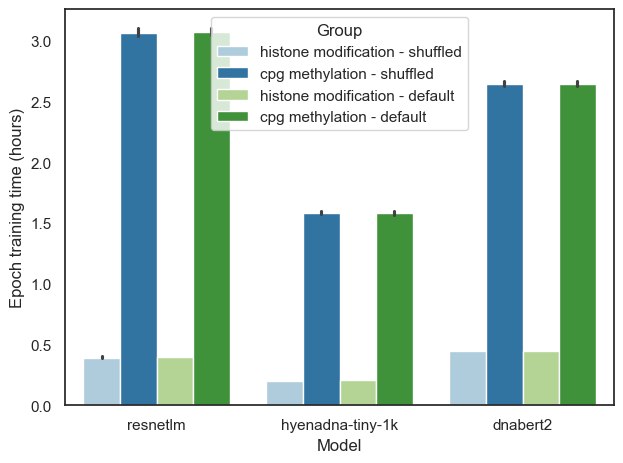

In [ ]:
df_losses['training_time_mins'] = df_losses['training_time']/60
df_losses['training_time_hours'] = df_losses['training_time_mins']/60

df_losses['Group'] = df_losses['Task'] + ' - ' + df_losses['Experiment']
sns.barplot(data=df_losses, x='Model', y='training_time_hours', hue='Group', palette=sns.color_palette('Paired'))

plt.ylabel('Epoch training time (hours)')
plt.tight_layout()
# plt.show()

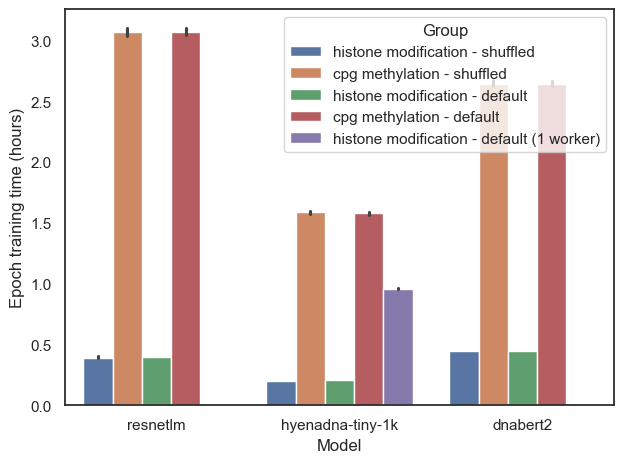

In [368]:
df_losses_all = pd.concat([df_losses, df_losses_hyenadna[df_losses_hyenadna['Experiment'] == 'default (1 worker)']])

df_losses_all['training_time_hours'] = df_losses_all['training_time']/(60*60)


df_losses_all['Group'] = df_losses_all['Task'] + ' - ' + df_losses_all['Experiment']
sns.barplot(data=df_losses_all, x='Model', y='training_time_hours', hue='Group')

plt.ylabel('Epoch training time (hours)')
plt.tight_layout()

## Histone HyenaDNA

The Histone DNA task uses 32 workers as default, which impact the level of shufflying.
Hence, we run the histone modification task using 1 worker and the hyenadna-tiny-1k model.

Text(0.5, 0.98, 'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

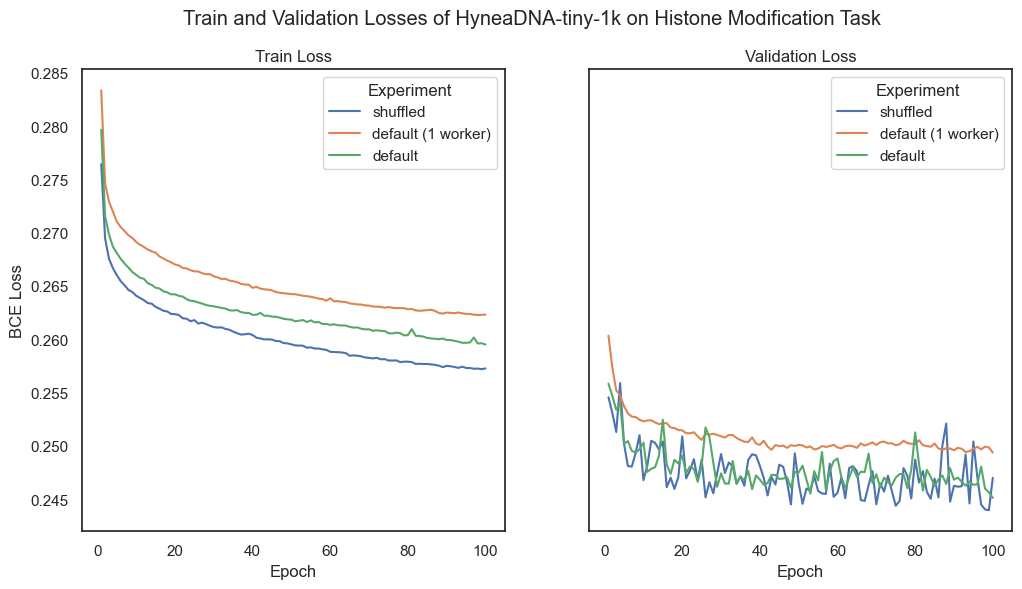

In [338]:
df_hyenadna = df_losses_hyenadna[df_losses_hyenadna['Task'] == 'histone modification']

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=True)

sns.lineplot(data=df_hyenadna, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_loss', hue='Experiment', ax=ax[1])
ax[0].set(title='Train Loss', ylabel='BCE Loss')
ax[1].set(title='Validation Loss')
plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

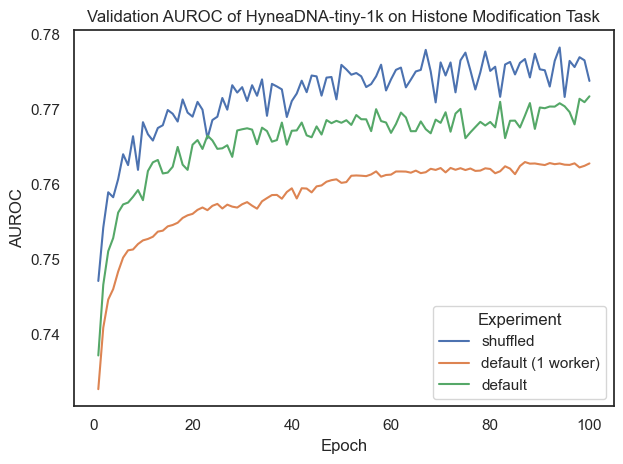

In [341]:
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_auroc', hue='Experiment')

plt.ylabel('AUROC')
plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on Histone Modification Task')
plt.tight_layout()

In [349]:
print_test_results(df_tests_hyenadna)

| Task                 | Experiment         | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:-------------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled           | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default            | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |
| histone modification | default (1 worker) | hyenadna-tiny-1k |  87.000 |       0.263 |            0.756 |
